In [1805]:
from IPython.display import HTML


HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Gender Inequality In Film
* Create a thesis
* Can use same dataset if you want
* 2-3 graphs
* Explain your data with text, draw a conslusion
#### Dataset: https://www.kaggle.com/tmdb/tmdb-movie-metadata/data 

In [5]:
%matplotlib inline
import csv
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import plotly as py
import plotly.graph_objs as go
import psycopg2
import datetime
import dateutil
import pandas as pd
# 

# Thesis

It is commonly known that women are a minority in the film industry, especially in the role of directing. How does the gender distribution vary when it comes to different production companies, departments, and specific job occupations? More importantly, is this dataset reflective of today's gender distribution in film and/or does it show a progression of more women joing the film industry over time? Though I believe that the 5000 movie dataset will speak to the fact that there is a significant difference between the proportion of men versus the proprotion of women holding film industry occupations, I hypothesize that this dataset will not reflect with much accuracy today's gender distribution in film as it is not a true representation of all the different kinds of movies that were released in any particular year. I propose that this will cause the proportion of women to appear smaller than it really is.

In [6]:
movies = pd.read_csv('clean_tmdb_5000_movies.csv')
movies['id'] = movies['id'].apply(lambda x : str(x))
#################
credits = pd.read_csv('clean_tmdb_5000_credits.csv', low_memory=False)
# getting rid of unnamed columns
credits = credits.loc[:, ~credits.columns.str.contains('^Unnamed')]
# dropping title column from credits df
credits = credits.drop(['title'], axis=1)
# merge movies and credits
movieData = pd.merge(movies, credits, on='id')
# # dropping duplicates
movieData = movieData.drop_duplicates()
# movieData['release_date'].value_counts()

In [ ]:
prod_companies = movieData.production_companies.tolist()
date = movieData.release_date.tolist()
crew = movieData.crew.tolist()
movie = movieData.title.tolist()

prod_crew = {'production_company': [], 'department': [], 'gender': [], 'job': [], 'release_date': [], 'movie': []}                          
count = 0                         
for i in range(0, len(prod_companies)):
   # turning string into dict
    if prod_companies[i] != '[]' and not isinstance(crew[i], float) and crew[i] != '[]':
        p_dict = ast.literal_eval(prod_companies[i][1:-1])
        # formatting crew strings
        y = ''
        x = crew[i][1:-1].split('{')
        for a in range(1, len(x)):
            if a != len(x)-1:
                if x[a][-3] == '}':
                    y = y + '{' + x[a]
            else:
                if x[a][-1] == '}':
                    y = y + '{' + x[a]  
        c_dict = ast.literal_eval(y)

        # adding to the prod_crew dictionary
        if isinstance(p_dict, tuple) and isinstance(c_dict, tuple):
            for k in range(len(p_dict)):
                for j in range(len(c_dict)):
                    prod_crew['production_company'].append(p_dict[k]['name'])
                    prod_crew['department'].append(c_dict[j]['department'])
                    prod_crew['gender'].append(c_dict[j]['gender'])
                    prod_crew['job'].append(c_dict[j]['job'])
                    prod_crew['release_date'].append(date[i])
                    prod_crew['movie'].append(movie[i])
        elif isinstance(p_dict, dict) and isinstance(c_dict, tuple):
            for z in range(len(c_dict)):
                prod_crew['production_company'].append(p_dict['name'])
                prod_crew['department'].append(c_dict[z]['department'])
                prod_crew['gender'].append(c_dict[z]['gender'])
                prod_crew['job'].append(c_dict[z]['job'])
                prod_crew['release_date'].append(date[i])
                prod_crew['movie'].append(movie[i])
        elif isinstance(p_dict, dict) and isinstance(c_dict, dict):
            prod_crew['production_company'].append(p_dict['name'])
            prod_crew['department'].append(c_dict['department'])
            prod_crew['gender'].append(c_dict['gender'])
            prod_crew['job'].append(c_dict['job'])
            prod_crew['release_date'].append(date[i])
            prod_crew['movie'].append(movie[i])
        elif isinstance(p_dict, tuple) and isinstance(p_dict, dict):
            for x in range(len(p_dict)):
                prod_crew['production_company'].append(p_dict[x]['name'])
                prod_crew['department'].append(c_dict['department'])
                prod_crew['gender'].append(c_dict['gender'])
                prod_crew['job'].append(c_dict['job'])
                prod_crew['release_date'].append(date[i])
                prod_crew['movie'].append(movie[i])

# print(len(prod_crew['production_company']))
# print(len(prod_crew['department']))
# print(len(prod_crew['gender']))
# print(len(prod_crew['job']))
# print(len(prod_crew['release_date']))

In [ ]:
crew = pd.DataFrame(prod_crew)
# nnn = crew.groupby('production_company').mean().reset_index()
# crew.loc[crew['production_company'] == 'Walt Disney Pictures']
crew['release_date'] = pd.to_datetime(crew.release_date)
# crew

## Gender Proportions Across Production Companies
  Aftering splitting the 5000 movie dataset so that each crew member per production company per movie had its own entry in the dataframe, I wanted to know whether or not the proprotion of men versus the proprotion of women was in any way significantly different or similar across production companies. In this particular dataset, there are close to 5,000 production companies. This seems like a lot, but not all the production companies are based in the U.S. and many only contributed to one film in the movie dataset. In order to create a graph that accurately represented the proportion of men and women, I dropped entries in the dataframe were the total of men and women was less than 500. 

Here are the top 5 production companies with the greatest difference in male and female proportions:

In [3]:
p = pd.crosstab([crew.production_company], crew.gender).reset_index()
p = p.rename(index=int, columns={0: "unknown", 1: "female", 2:"male"})
# p.head()

NameError: name 'pd' is not defined

In [1678]:
# calculating total of females + males for each production_company
p['total'] = p.apply(lambda gender: gender.female + gender.male, axis=1)
# dropping rows where total is less than 100
p = p.drop(p.index[p.total < 500])
p['f_proportion'] = p.apply(lambda gender: gender.female/gender.total*100, axis=1)
p['m_proportion'] = p.apply(lambda gender: gender.male/gender.total*100, axis=1)
p['diff_proportions'] = p.apply(lambda gender: gender.m_proportion - gender.f_proportion, axis=1)
px = p.sort_values(['diff_proportions'], ascending=False)
px.head() 

gender,production_company,unknown,female,male,total,f_proportion,m_proportion,diff_proportions
4636,United Artists,853,112,835,947,11.826822,88.173178,76.346357
4779,Walt Disney Pictures,2440,289,1308,1597,18.096431,81.903569,63.807138
4547,TriStar Pictures,598,121,507,628,19.267516,80.732484,61.464968
1419,Epsilon Motion Pictures,651,104,427,531,19.585687,80.414313,60.828625
4583,Twentieth Century Fox Film Corporation,5695,697,2857,3554,19.611705,80.388295,60.776590


Text(0,0.5,'% of Total')

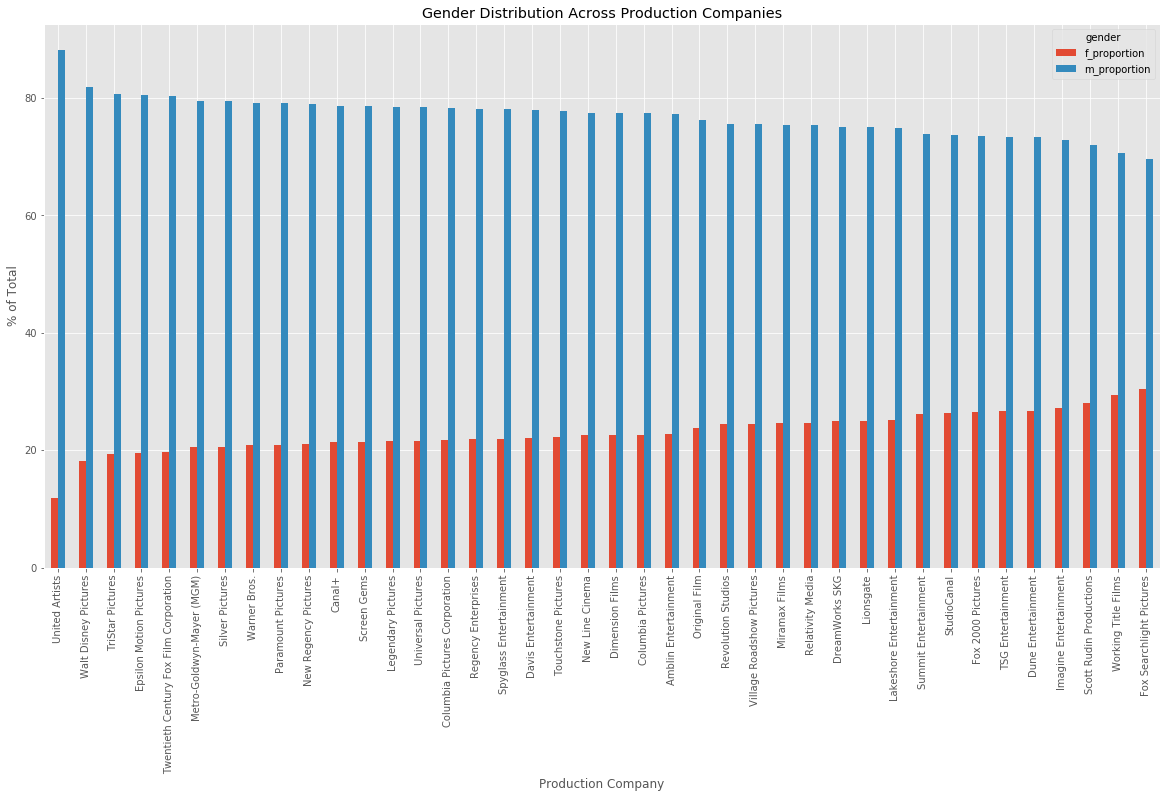

In [1679]:
prod_graph = p[['production_company', 'f_proportion', 'm_proportion']].sort_values('f_proportion')
prod_graph = prod_graph.set_index(['production_company'])
prod_graph.plot.bar(figsize=(20,10))
plt.title('Gender Distribution Across Production Companies')
plt.xlabel('Production Company')
plt.ylabel('% of Total')

Looking at this graph it is evident that the United Artists production company displays the most inequality between genders: females at 12% and males at 88% while Fox Searchlight Pictures has the smallest difference in female and male proportions: 30% and 70% respectively. It is especially interesting to note that Walt Disney Pictures is the second highest ranked when it comes to gender inequality. Most people would typically think of Walt Disney Pictures as one of the front runners in workplace equality given their many "Disney Princess" movies featuring women as protagonists. Further analysis reveals that Walt Disney Pictures' earliest movie in this dataset, Fantasia, dates back to 1940 where the crew was 100% male (unknowns are left out), but the proportions of men and women get better from there as more women join the workforce on account of WWII.

# Film Department
Viewing the proportion of males versus females across production companies is interesting, but not all to revealing as most production companies are typically all the same in having a 20% female 80% male population. To more specefically determine where these differences in male and female proprotions lie, let's take a look at the gender distribution across various departments in film. (Proportions were calculated only for totals greater than 500).

In [1680]:
d = pd.crosstab([crew.department], crew.gender).reset_index()
d = d.rename(index=int, columns={0: "unknown", 1: "female", 2:"male"})
# d.head()

In [1811]:
# calculating total of females + males for each production_company
d['total'] = d.apply(lambda gender: gender.female + gender.male, axis=1)
# dropping rows where total is less than 100
d = d.drop(d.index[d.total < 500])
d['f_proportion'] = d.apply(lambda gender: gender.female/gender.total*100, axis=1)
d['m_proportion'] = d.apply(lambda gender: gender.male/gender.total*100, axis=1)
d['diff_proportions'] = d.apply(lambda gender: gender.m_proportion - gender.f_proportion, axis=1)
dx = d.sort_values(['diff_proportions'], ascending=True)
# dx

Text(0,0.5,'% of Total')

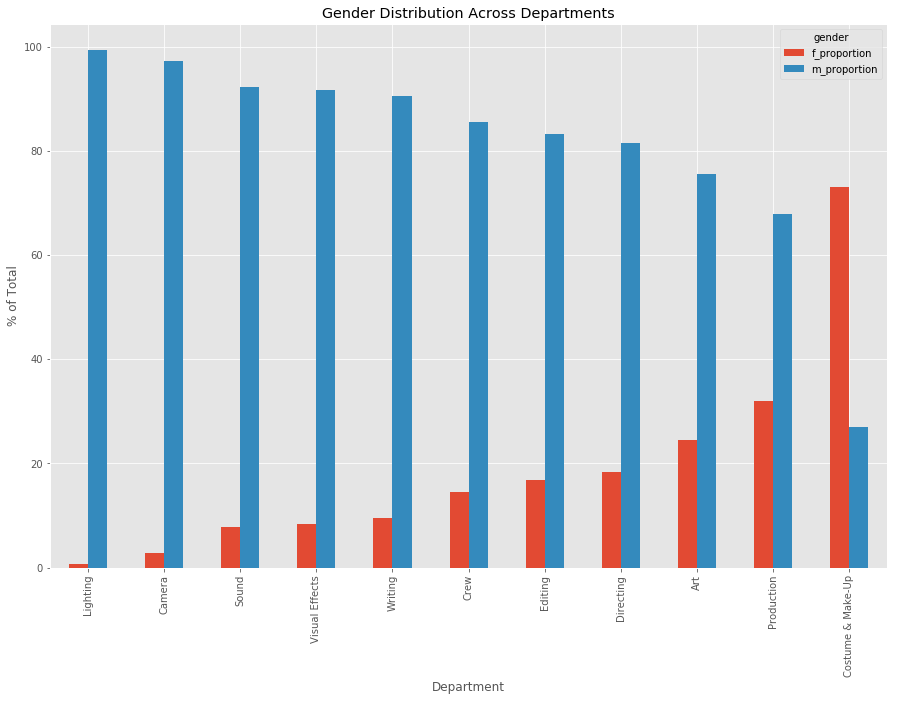

In [1682]:
dept_graph = d[['department', 'f_proportion', 'm_proportion']].sort_values('f_proportion')
dept_graph = dept_graph.set_index(['department'])
dept_graph.plot.bar(figsize=(15,10))
plt.title('Gender Distribution Across Departments')
plt.xlabel('Department')
plt.ylabel('% of Total')

This graph provides us many insights. For one, there is no department in which the proprotion of males and females even comes close to 50/50; the best is the Production department at 32% females and 68% males. Also, notably, but unsurprisingly, the Costume & Make-Up department is the only department in which females outnumber the male population 73% to 23%. What stood out to me in this graph was that the Lighting department is the worst equality wise. As stated earlier, when one hears about inequality in film, it is usually in reference to the role of Directing. It is interesting to see that there are departments doing far worse than Directing's 18% female 82% male proportion.

# Job Title
In this 5000 movie dataset, there are 417 different occcupations relating to film. How do these occupations measure up when comparing genders? Given the deparment distribution I don't believe there will be very many job titles where the proportions are equal to one another. (Proportions were calculated only for totals greater than 500).

In [1750]:
j = pd.crosstab([crew.job], crew.gender).reset_index()
j = j.rename(index=int, columns={0: "unknown", 1: "female", 2:"male"})
# j.head()

In [1818]:
# calculating total of females + males for each job
j['total'] = j.apply(lambda gender: gender.female + gender.male, axis=1)
# dropping rows where total is less than 100
j = j.drop(j.index[j.total < 500])
j['f_proportion'] = j.apply(lambda gender: gender.female/gender.total*100, axis=1)
j['m_proportion'] = j.apply(lambda gender: gender.male/gender.total*100, axis=1)
j['diff_proportions'] = j.apply(lambda gender: gender.m_proportion - gender.f_proportion, axis=1)
jx = j.sort_values(['diff_proportions'], ascending=False)
# jx

Text(0,0.5,'% of Total')

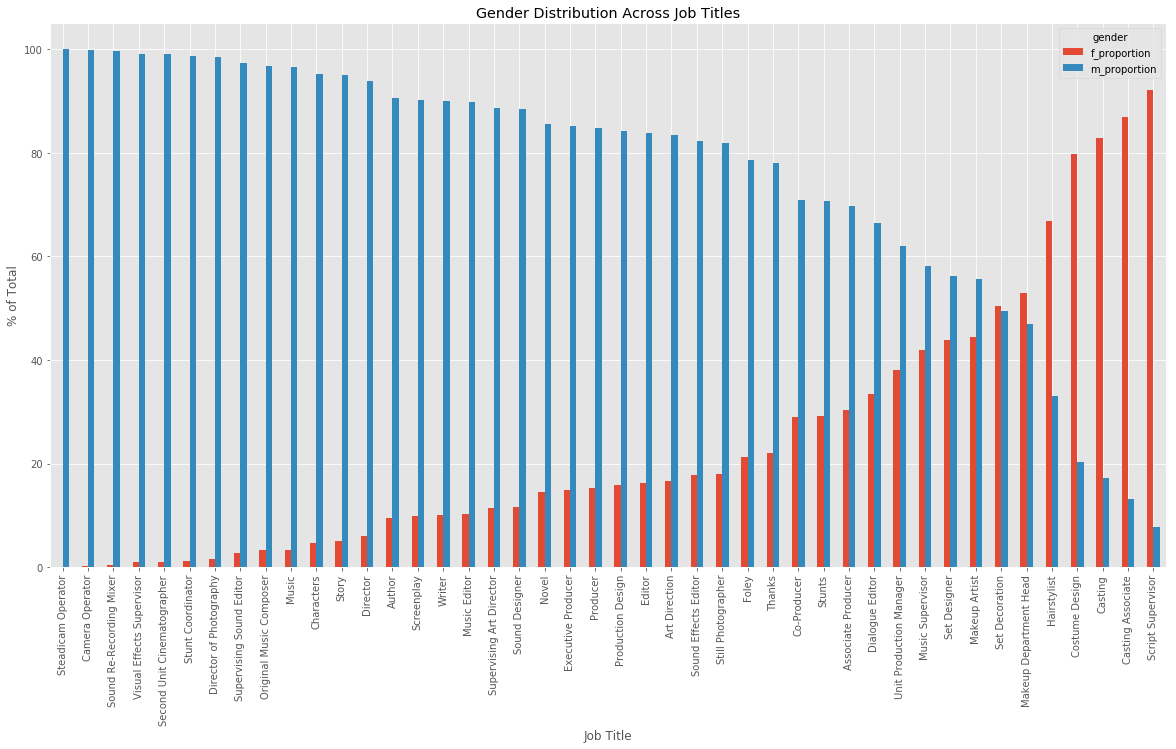

In [1685]:
job_graph = j[['job', 'f_proportion', 'm_proportion']].sort_values('f_proportion')
job_graph = job_graph.set_index(['job'])
job_graph.plot.bar(figsize=(20,10))
plt.title('Gender Distribution Across Job Titles')
plt.xlabel('Job Title')
plt.ylabel('% of Total')

As I predicted, there are very few film occupations in which male and female proportions are relatively the same: Music Supervisor, Set Designer, Makeup Artist, Set Decoration, and Makeup Department Head appear to be the best when it comes to equaltiy (Set Decoration being the ultimate best at 51%F 49%M).

# The Center for the Study of Women in Television & Film 
How does the 5000 movie dataset stack up against real world data? Unfortunately, I was unable to find a csv file that I could read in and really do a deep exploration with in comparing my dataset to real-world data. However, The Center for the Study of Women in Television & Film, an organization that focuses solely on conducting research studies relating to women in film, recently published their 2016 report on women behind the sceens roles in film. To find out how my data compares, I hand typed the numbers presented in the PDF below into a dataframe. 

The Center for the Study of Women in Television & Film website:
* http://womenintvfilm.sdsu.edu/research/


The Celluloid Ceiling: Behind-the-Scenes Employment of Women on the Top 100, 250, and 500 Films of 2016 (PDF):
* http://womenintvfilm.sdsu.edu/wp-content/uploads/2017/01/2016_Celluloid_Ceiling_Report.pdf

### The Center for the Study of Women in Television & Film Data:

In [1796]:
center = pd.DataFrame({'job':['Director', 'Writer', 'Executive Producer', 'Producer',
                             'Editor'], 'f_proportion':[7.0, 13.0, 17.0, 24.0, 17.0]})
center

,f_proportion,job
0,7.0,Director
1,13.0,Writer
2,17.0,Executive Producer
3,24.0,Producer
4,17.0,Editor


In [1802]:
yy = pd.crosstab([crew.job, crew.release_date], crew.gender).reset_index()
yy = yy.rename(index=int, columns={0: "unknown", 1: "female", 2:"male"})
yy['total'] = yy.apply(lambda gender: gender.female + gender.male, axis=1)
yy = yy[(yy['release_date'].dt.year == 2016)]
# df.drop(pd.to_datetime('2000-01-06'))
# xx = pd.date_range(start='2016-01-01', end='2016-12-31'

In [1803]:
new = yy.groupby('job').sum().reset_index()
new = new.drop(new.index[new.total < 5])
new['f_proportion'] = new.apply(lambda gender: gender.female/gender.total*100, axis=1)
new['m_proportion'] = new.apply(lambda gender: gender.male/gender.total*100, axis=1)
new['diff_proportions'] = new.apply(lambda gender: gender.m_proportion - gender.f_proportion, axis=1)
# new

In [1795]:
select_jobs = new[['job', 'f_proportion']]
combine = pd.merge(center, select_jobs, on='job')
combine = combine.rename(columns={'f_proportion_x': 'center_data', 'f_proportion_y': 'my_data'})
# combine['diff_proportions'] = combine.apply(lambda row: row.my_movies - row.center_data, axis=1)
# combine

Text(0.5,0,'% of Total')

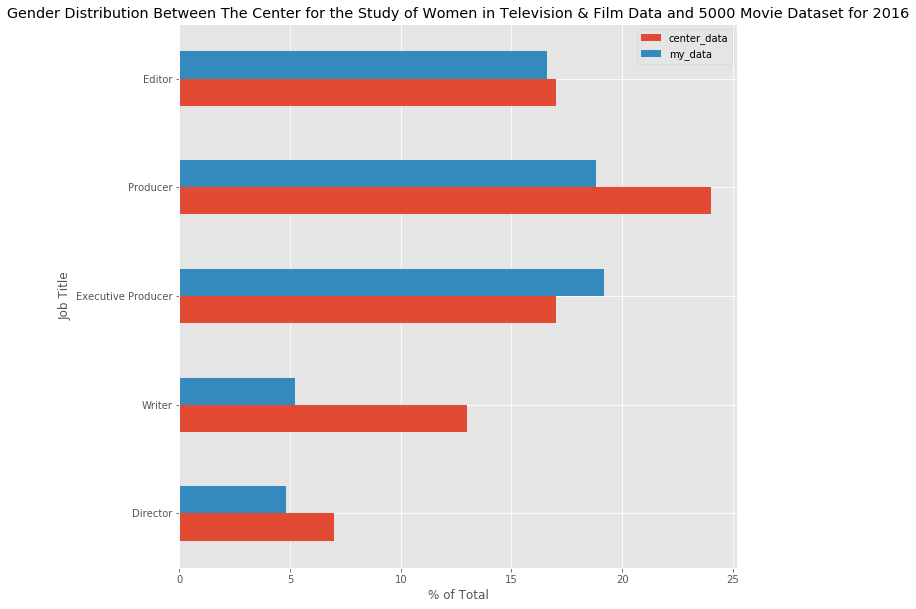

In [1797]:
combine_graph = combine.set_index(['job'])
combine_graph.plot.barh(figsize=(10,10))
plt.title('Gender Distribution Between The Center for the Study of Women in Television & Film Data and 5000 Movie Dataset for 2016')
plt.ylabel('Job Title')
plt.xlabel('% of Total')

Comparing the 5000 movie datset with The Center for the Study of Women in Television & Film for the year 2016, it appears that the Center's proportions of females is greater in every job title save for Executive Producer, which is particularly interesting. The smallest differene in proportions between the two datasets was .40% for Editor; the greatest being 8% for Writer. It is expected that the Center's female proportions would fair better than the 5000 movie dataset because its study was conducted on a much bigger scale involving a greater sampling size. Conclusivley, it doesn't look like the 5000 movie datset is accurate when it comes to reflecting today's gender distribution in film, at least for the year 2016.

In [1819]:
combine['diff_proportions'] = combine.apply(lambda row: row.center_data - row.my_data, axis=1)
# combine

# Time Series Analysis 
The 5000 movie dataset is not very reflective of today's gender distribution in film, but does it at least show a progression in the number of women in the film occupation over the years?

In [1798]:
y = pd.crosstab([crew.release_date], crew.gender).reset_index()
y = y.rename(index=int, columns={0: "unknown", 1: "female", 2:"male"})

In [1799]:
y['total'] = y.apply(lambda gender: gender.female + gender.male, axis=1)
y = y.drop(y.index[y.total < 220])
y['f_proportion'] = y.apply(lambda gender: gender.female/gender.total*100, axis=1)
y['m_proportion'] = y.apply(lambda gender: gender.male/gender.total*100, axis=1)
y['diff_proportions'] = y.apply(lambda gender: gender.m_proportion - gender.f_proportion, axis=1)
# making release_date into a datetime series
y['release_date'] = pd.to_datetime(y.release_date)

In [1800]:
# y_graph = y[['release_date', 'f_proportion', 'm_proportion']].sort_values('release_date')
# y_graph = y_graph.set_index(['release_date'])
# y_graph.plot.bar(figsize=(20,10))
# plt.title('Gender Distribution in Film Over the Last Two Decades')
# plt.xlabel('Date')
# plt.ylabel('% of Total')

Text(0,0.5,'% Female')

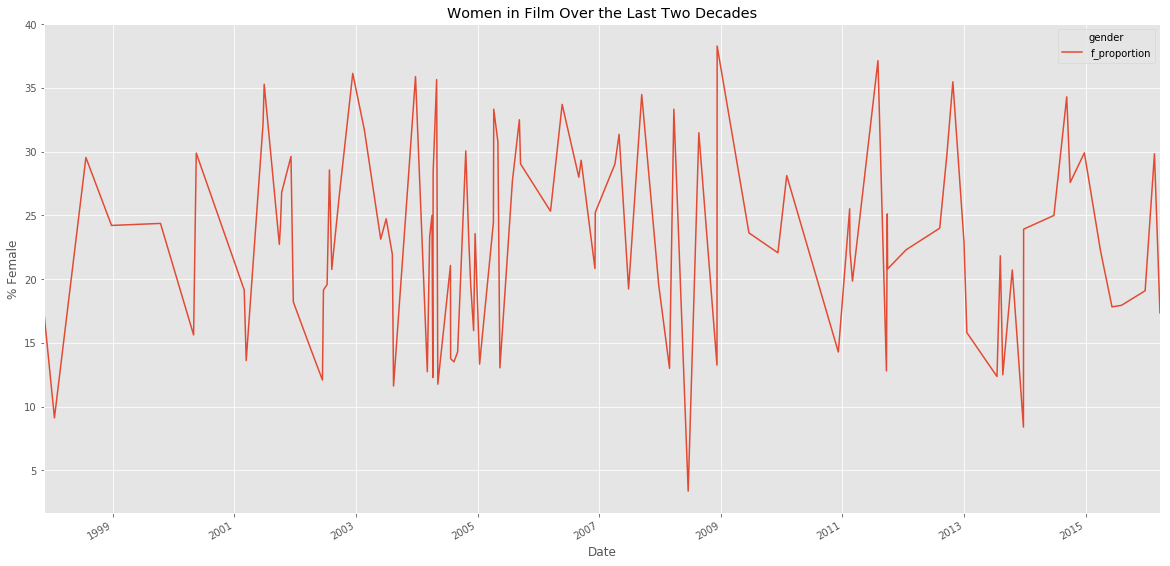

In [1740]:
y_line = y[['release_date', 'f_proportion']].sort_values('release_date')
y_line = y_line.set_index(['release_date'])
y_line.plot.line(figsize=(20,10))
plt.title('Women in Film Over the Last Two Decades')
plt.xlabel('Date')
plt.ylabel('% Female')

This movie dataset does not appear to show a positive trend over the last two decades in the number of women holding film related occupations. While the graph does have its spikes, it is a little disheartening to see that there never came a time when the proportion of women in any given year came close to 50%. 

# Conclusion

There are a lot of take aways from the analysis of male and female proportions in the 5000 movie dataset. For one, the film occupations that had the most equality were Music Supervisor, Set Designer, Makeup Artist, Makeup Department Head, and Set Decoration. The worst was Steadicam Opereator where 100% of the 561 total people occupying this position were male. The occupation of Director was about as disparaging as the news makes it out to be: only 6% of these positions were held by women. When comparing the 5000 movie dataset with data produced by The Center for the Study of Women in Television & Film, the 5000 movie dataset recorded significantly lower percentages of women occupying Writer and Producer positions and a higher percentage for Executive producer positions, making the 5000 movie dataset not a great reflector of today's gender distribution in film. Plotting the percentages of females in film against time, there appears to be no positive trend in the number of women holding film occupations as time progressed. 

Final thoughts: Though this dataset is a fine start when it comes to taking a quick look at gender porportions in the film industry, it does contain flaws that give rise to concern about its accuracy. The major flaw of this dataset is that it contians many entries in which the gender of the person was unknonwn, causing the accuracy of the data to suffer from nonresponse. In order to draw truthful, comprehensive conclusions about gender porportions in film, it is essential that the gender of each member be known. Moreover, we do not know if the movies in this dataset were randomly selected. Most likely they were not which makes the data biased. Overall, I enjoyed working with this dataset and felt that I made some interesting discoveries, though I would promote caution in using this dataset to make conjectures about the real-world population of women occupying jobs in the film industry.